<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/ImageGeneration/CNN_Texture_Interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Texture interpolation with CNNs in PyTorch

## Introduction

This practical session explains how to implement the Texture Interpolation between arbitrary textures based on the algorithm described on [J. Vacher, A. Davila, A. Kohn, and R. Coen-Cagli,Texture interpolation for probingvisual perception, Advances in Neural Information Processing Systems, (2020)](https://arxiv.org/pdf/2006.03698.pdf). 

**Texture interpolation:** 

Texture interpolation or mixing consists of generating new textures by mixing different examples of textures.

**References:**

This practical session is based on several resources:

*   Original code: https://github.com/JonathanVacher/texture-interpolation
*   Functions to manage images: https://github.com/trsvchn/deep-textures
*   Texture Synthesis Notebook: https://github.com/storimaging/Notebooks/blob/master/CNN_Texture_Synthesis.ipynb
*   Tutorial used for some explanation: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

**Authors:**
* Lucía Bouza

Let us recall the algorithm proposed by Gatys et al. and implemented in the Texture synthesis notebook. 

We will now replace the loss function with the one suggested in the aforementioned [paper](https://arxiv.org/pdf/2006.03698.pdf). *Wasserstein* loss $L_W$ aims to minimize with respect to $x$ the Wasserstein distance between the input and the target feature vectors :

$$
L_W(x, u) = \sum_{\text{for selected layers } \ell} \left\| \operatorname{mean}(x_\ell) - \operatorname{mean}(u_\ell) \right\|^2 + B(\operatorname{Cov}(x_\ell), \operatorname{Cov}(u_\ell))^2
$$
where:
- $ B(X, Y)^2 = \operatorname{Tr} (X + Y -2(X^{1/2}YX^{1/2})^{1/2})$ is the Bures metric between symmetric matrices $X$ and $Y$
- $x_\ell$ denotes the feature vector of layer $\ell$ for image $x$ which is our optimzation variable, 
- $u_\ell$ denotes the feature vector of layer $\ell$ for input image $u$. 

As soon as the covariance matrices commute, we simply have:
$$ 
B(X, Y)^2 = \left\| X^{1/2} - Y^{1/2} \right\|^2_F.
$$
In what follows we will always assume that the covariance matrices commute.

We can have $K$ target textures to interpolate. The interpolation $x^\star$ can be found with the following expression:

$$
x^\star = \operatorname{argmin}_x  \sum^{K}_{k=1} \lambda_k L_W(x, u_k) 
$$
where the wieghts $\lambda_k >0$ are such that $ \sum^{K}_{k=1} \lambda_k = 1$. 

In this notebook we will show an example using $K=2$ textures.

Here are some examples made with this notebook, using $K=2$ textures.

![Text](https://raw.githubusercontent.com/storimaging/Images/main/SupportImages/TannatTulum.jpg)

![Text](https://raw.githubusercontent.com/storimaging/Images/main/SupportImages/christmasdaisies.jpg)

## Importing packages

Below is a list of packages needed to implement texture interpolation. PyTorch version used to run this notebook is **1.11.0+cu113** (to check the installed version, use `torch.__version__`)

* `torch` (essential packages for neural networks with PyTorch)
* `torch.optim` (efficient gradient descent)
* `mse_loss` (to compute loss)
* `torchvision.models` (to get the vgg network)
* `torchvision.transforms.functional` (to transform images into tensors)
* `PIL.Image, matplotlib.pyplot` (to load and display images)
* `os` (to execute scripts with parameters into python code)

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.functional import mse_loss
import torchvision.models as models
from torchvision.transforms.functional import resize, to_tensor, normalize, to_pil_image

from PIL import Image
import matplotlib.pyplot as plt
import os

## Loading images

In the next section we will load images. Here we will just get, display and save the image, without doing any changes to it. 


In [2]:
texture_imgnames = ["arabicbread.jpg", "redfruits.jpg", "grapes.jpg", "tannat.jpg", "daisies.jpg","tulum.jpg","cloudsky.jpg", "monetwaterlily.jpg", "batlloexit.jpg", "christmas.jpg", "cheesecake.jpg"]

for fname in texture_imgnames:
    os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/Textures/"+fname)
    img = Image.open(fname)

## Set a device

Next, we need to choose which device to run the algorithm on. Running the algorithm on large images takes longer and will go much faster when running on a GPU. We can use `torch.cuda.is_available()` to detect if there is a GPU available. Next, we set the `torch.device`. The `.to(device)` method is used to move tensors or modules to a desired device, we will use it in next sections. 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
!nvidia-smi

## Data preparation

The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. 

An important detail to note is that neural networks from the torch library are trained with tensor values ranging from 0 to 1. Additionally, VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] (mean and standard deviation of Imagenet). We will need to normalize the image tensor before sending it into the network.

Here are some helper functions for loading, displaying and transforming into tensors.

In [4]:
#@title
# Utilities
# Functions to manage images

MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

# Based on Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py
def prep_img(image: str, size=None, mean=MEAN, std=STD):
    """Preprocess image.
    1) load as PIl
    2) resize
    3) convert to tensor
    5) remove alpha channel if any
    4) normalize
    """
    im = Image.open(image)
    texture = resize(im, size)
    texture_tensor = to_tensor(texture).unsqueeze(0)
    if texture_tensor.shape[1]==4:
        print('removing alpha chanel')
        texture_tensor = texture_tensor[:,:3,:,:]
    texture_tensor = normalize(texture_tensor, mean=mean, std=std)
    return texture_tensor

# Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py
def denormalize(tensor: torch.Tensor, mean=MEAN, std=STD, inplace: bool = False):
    """Based on torchvision.transforms.functional.normalize.
    """
    tensor = tensor.clone().squeeze() 
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    return tensor

# Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py
def to_pil(tensor: torch.Tensor):
    """Converts tensor to PIL Image.
    Args: tensor (torch.Temsor): input tensor to be converted to PIL Image of torch.Size([C, H, W]).
    Returns: PIL Image: converted img.
    """
    img = tensor.clone().detach().cpu()
    img = denormalize(img).clip(0, 1)
    img = to_pil_image(img)
    return img


def printResults(target1, target2, opt_img, iter, loss, lambda1):
    """ Displays the intermediate results of the main iteration
    """ 
    print('Iteration: %d, loss: %f'%(iter, loss.item()))
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    axes[0].imshow(to_pil(target1))
    axes[0].set_title('Texture 1. Lambda: ' + str(lambda1))
    axes[1].imshow(to_pil(target2))
    axes[1].set_title('Texture 2. Lambda: ' + str(1-lambda1))
    axes[2].imshow(to_pil(opt_img.squeeze(0)))
    axes[2].set_title('Interpolation')
    fig.tight_layout()
    plt.pause(0.05)

## Model

Now we need to import a pretrained neural network. We will use a 19-layer VGG network from PyTorch.

VGG's PyTorch implementation is a module split into two sequential child modules: features (containing convolution and pooling layers) and classifier (containing fully connected layers). For the texture interpolation task, we are only interested in the layers of the features module. We won't let the parameters change: the network is already trained and used as an image transformation.

On the output of the following commands, you can see the `feature` module structure. The indices will help to select the necessary layers for the algorithm.



In [ ]:
cnn = models.vgg19(weights='IMAGENET1K_V1').features.to(device).eval()
cnn.requires_grad_(False)

According to the algorithm explained at the beginning of this notebook, we need to access the outputs of some selected intermediate layers. In order to access the outputs of the layers on the PyTorch VGG19 network, we need to register a hook on each layer we need. Hooks are functions, which can be attached to each layer and called each time the layer is used. You can register a hook before or after the forward pass, or after the backward pass. We will define a function `save_output` that will be triggered after the forward pass, for each layer of the `features` module. 

The layer outputs will be stored in a dictionary where the key is the layer index and the value is the layer output tensor.

We must define which layers will be part of the optimization. Using the indices of layers, we select the layers to use in the algorithm. We choose the outputs of the first five Conv2d layers, so indices are: 0, 2, 5, 7 and 10. 

In [7]:
# Initialize outputs dic
outputs = {}

# Hook definition
def save_output(name):
    
    # The hook signature
    def hook(module, module_in, module_out):
        outputs[name] = module_out
    return hook

# Define layers
layers = [0, 2, 5, 7, 10]

# Register hook on each layer with index on array "layers"
for layer in layers:
    handle = cnn[layer].register_forward_hook(save_output(layer))

## Loss function

We need to define the Loss function as explained at the beginning of the notebook. We first define some helper functions to calculate the mean, covariance and square root of a positive definite matrix.

In [9]:
# Helper Functions

def Mean_and_Cov(tensor):
    
    a, b, c, d = tensor.size() 
    X = tensor.view(a*b, c*d)
    M_tensor = X.mean(1)
    C_tensor = torch.cov(X)
    return M_tensor, C_tensor

# Jonathan Vacher's code
# https://github.com/JonathanVacher/texture-interpolation/blob/master/texture-synthesis-algorithm/models/utils.py
def sqrtm(input):
    """Square root of a positive definite matrix.
    NOTE: matrix square root is not differentiable for matrices with
          zero eigenvalues.
          
    See Lin, Tsung-Yu, and Subhransu Maji. 
        "Improved Bilinear Pooling with CNNs." BMVC 17 
    """    
    dim = input.shape[0]
    norm = torch.norm(input.double())
    Y = input/norm
    I = torch.eye(dim,dim,device=input.device).type(input.dtype)
    Z = torch.eye(dim,dim,device=input.device).type(input.dtype)
    for i in range(15):
        T = 0.5*(3.0*I - Z.mm(Y))
        Y = Y.mm(T)
        Z = T.mm(Z)
    sqrtm = Y*torch.sqrt(norm)

    return sqrtm

We now define a function to calculate the Wasser Loss. We use the following: $ B(Cov(x_l), Cov(u_l))^2 = \left\| Cov(x_l)^{1/2} - Cov(u_l)^{1/2} \right\|^2_F $.

In [10]:
def WasserLoss(input, M_target, SqrtCov_target):

    M_x, C_x = Mean_and_Cov(input)
    SqrtCov_tnsr = sqrtm(C_x)
    return mse_loss(M_x, M_target, reduction='sum') + mse_loss(SqrtCov_tnsr, SqrtCov_target, reduction='sum')

## Optimizer and initialization

In this section we choose our textures to interpolate. These images are converted into tensors, then we compute the activations of the selected layers. Note that here we will interpolate between 2 textures, but we can easily modify the algorithm to interpolate between more than 2 images. 

For each activation of the target image, we compute the mean and the squareroot of the covariance matrix. This is done only once.


In [11]:
# Load target images
# Select from the list: ["arabicbread.jpg", "redfruits.jpg", "grapes.jpg", "tannat.jpg", "daisies.jpg","tulum.jpg","cloudsky.jpg", "monetwaterlily.jpg", "batlloexit.jpg", "christmas.jpg", "cheesecake.jpg"]
input_image_name1 = "tannat.jpg"
input_image_name2 = "tulum.jpg"
img_size = 256

# Prepare texture data
target1 = prep_img(input_image_name1, img_size).to(device)
target2 = prep_img(input_image_name2, img_size).to(device)

# Forward pass using targets textures for get activations of selected layers (outputs).
cnn(target1)
outputs_target1 = [outputs[key] for key in layers]
cnn(target2)
outputs_target2 = [outputs[key] for key in layers] 

# Get Mean, Cov and SQRT of Cov for each activation 
M_outputs_target1, C_outputs_target1, M_outputs_target2, C_outputs_target2, SqrtCov_target1, SqrtCov_target2 = list(), list(), list(), list(), list(), list()

for i in range(len(layers)):
    M_target1, C_target1 = Mean_and_Cov(outputs_target1[i])
    M_target2, C_target2 = Mean_and_Cov(outputs_target2[i])
    M_outputs_target1.append(M_target1)
    C_outputs_target1.append(C_target1)
    M_outputs_target2.append(M_target2)
    C_outputs_target2.append(C_target2)
    SqrtCov_target1.append(sqrtm(C_target1))
    SqrtCov_target2.append(sqrtm(C_target2))


Then, we draw the random initialization. This tensor needs to be optimized, so we set `requires_grad` to `True`.

We use L-BFGS algorithm to run gradient descent. We will create a PyTorch L-BFGS optimizer `optim.LBFGS` and pass the `opt_img` image to it as the tensor to optimize.

In [12]:
# Random init for image opt_img
opt_img = torch.randn_like(target1)
opt_img.requires_grad=True

# Set optimizer
optimizer = optim.LBFGS([opt_img], lr=0.1, max_iter=20)

## Running texture interpolation

We are now able to perform texture Interpolation. 

At each iteration of the network, it receives an updated input and computes new losses between target activations and opt activations (activations of the layers selected for the image that it is being optimized). 

As we are interpolating 2 textures we just have $\lambda_1$ and $\lambda_2$ as weights of each texture and $\lambda_2 = 1 - \lambda_1$.

We will run the backward methods of each loss module to dynamically compute their gradients. The optimizer requires a “closure” function, which reevaluates the module and returns the loss.

Iteration: 0, loss: 7024.791504


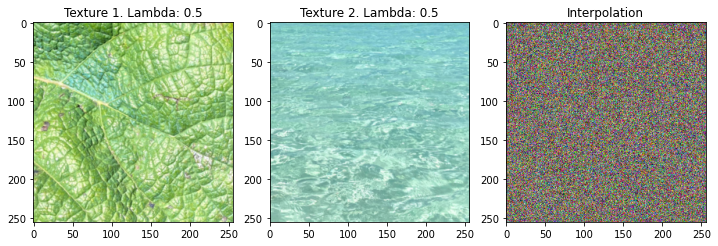

Iteration: 500, loss: 253.772049


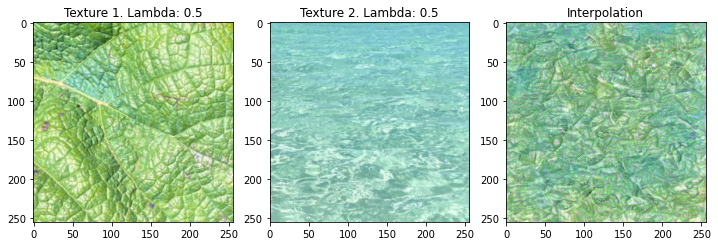

Iteration: 1000, loss: 253.116470


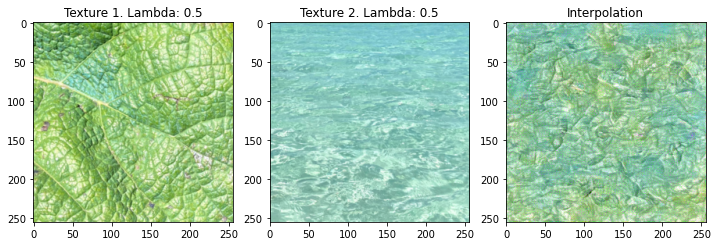

In [13]:
# Inspired on Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/example.ipynb

iter_ = 0

# Main loop of texture interpolation
def textureInterpolation(lambda_1, n_iters, log_every, printresults):

    global iter_
    iter_ = 0
    
    while iter_ <= n_iters:

        def closure():
            global iter_

            optimizer.zero_grad()

            # Forward pass using opt_img. Get activations of selected layers for image opt_img (outputs).
            cnn(opt_img)
            opt_outputs = [outputs[key] for key in layers] 
            
            # Compute loss
            tex_score_1, tex_score_2 = 0, 0
        
            for i in range(len(opt_outputs)):
                tex_score_1 += WasserLoss(opt_outputs[i], M_outputs_target1[i], SqrtCov_target1[i])
                tex_score_2 += WasserLoss(opt_outputs[i], M_outputs_target2[i], SqrtCov_target2[i])

            loss = lambda_1*tex_score_1 + (1-lambda_1)*tex_score_2        
            loss.backward()

            # Display results: print Loss value and show images
            if (iter_ % log_every == 0 and printresults):
                printResults(target1, target2, opt_img, iter_, loss, lambda_1)

            iter_ += 1
            return loss

        optimizer.step(closure)
    
    return opt_img


opt_img = textureInterpolation(lambda_1 = 0.5, n_iters = 1000, log_every = 500, printresults=True)

## Performing texture interpolation by moving barycenters

In this section, we sample the path interpolating between two textures, that is, we compute the interpolating texture for different values ​​of  $\lambda_1$ starting from a common random initialization.


In [14]:

def TextureInterpolationBarycenters (n_iters = 1000, n_Interpolations=10):
    
    # Initialize list of images
    image_list = []
    init = torch.randn_like(target1)

    for i in range(n_Interpolations):
        print("Computing interpolation", i+1, "/", n_Interpolations)

        # Random init for image opt_img
        opt_img = init.detach()
        opt_img.requires_grad=True

        # Set optimizer
        optimizer = optim.LBFGS([opt_img], lr=0.1, max_iter=20)

        # run interpolation
        opt_img_final = textureInterpolation(lambda_1 = i/(n_Interpolations-1), n_iters = n_iters, log_every=  n_iters//10 , printresults=False)

        # Store for comparison
        image_list.append(opt_img_final.clone().detach().to("cpu"))

    return image_list
    
image_list = TextureInterpolationBarycenters (n_iters = 1000, n_Interpolations=10)

Computing interpolation 1 / 10
Computing interpolation 2 / 10
Computing interpolation 3 / 10
Computing interpolation 4 / 10
Computing interpolation 5 / 10
Computing interpolation 6 / 10
Computing interpolation 7 / 10
Computing interpolation 8 / 10
Computing interpolation 9 / 10
Computing interpolation 10 / 10


By running the following cell, we can compare the different interpolations.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

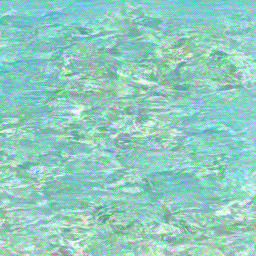

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

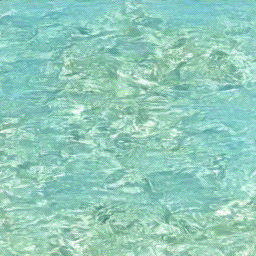

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

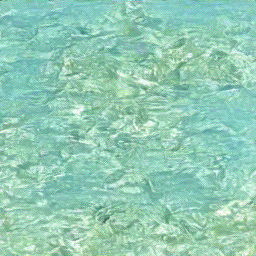

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

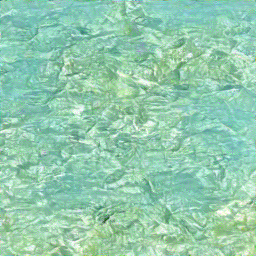

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

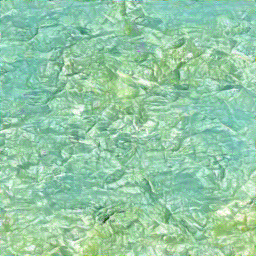

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

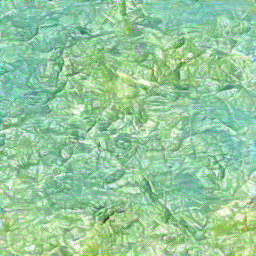

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

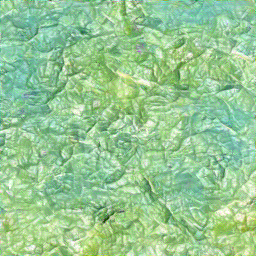

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

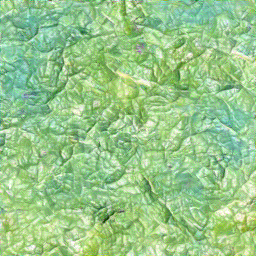

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

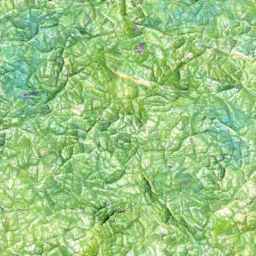

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

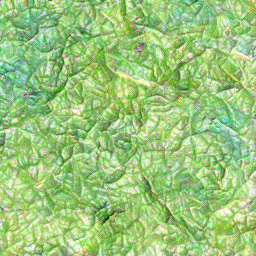

<IPython.core.display.Javascript object>

In [15]:
from google.colab import widgets

def compare_images(imgs):
    labels = ['image ' + str(i) for i in range(len(imgs))]
    tb = widgets.TabBar(labels, location='top')
    for i, img in enumerate(imgs):
        with tb.output_to(i, select=(i == 0)):
            display(to_pil(img.squeeze(0)))

compare_images(image_list)